# 12-2 LangGraph로 구현하는 에이전트

In [1]:
from dotenv import load_dotenv

# 환경변수 파일(.env)을 불러온다
load_dotenv()

True

In [ ]:
import os
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_pinecone import PineconeVectorStore

# 업스테이지의 임베딩 모델을 초기화한다.
embedding = OpenAIEmbeddings(
    base_url='https://api.upstage.ai/v1/solar',
    api_key=os.getenv("UPSTAGE_API_KEY"),
    model='embedding-passage',
    check_embedding_ctx_length=False 
)

# ChatOpenAI를 활용해서 사용할 LLM을 선언한다
llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')


index_name = "house-tax-index"
# 벡터 저장소는 Chroma를 사용해도 무방하다.
vector_store = PineconeVectorStore.from_existing_index( 
                       index_name=index_name,
                       embedding=embedding, )

retriever = vector_store.as_retriever( search_kwargs={"k": 3})
question = '내가 10억짜리 집을 2채 가지고 있다면 세금을 얼마나 내나요?'


/Users/jasonkang/personal/langgraph-book/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langgraph.graph import StateGraph, MessagesState

# MessagesState를 사용하여 그래프를 초기화한다.
# 이전 방식은 각 노드가 직접 상태를 수정했지만, 이제는 도구들이 메시지를 주고받는 방식으로 동작한다.
graph_builder = StateGraph(MessagesState)


In [4]:
# LangGraph를 위한 공제액 계산 로직을 구성한다.
# 여러 체인을 조합하여 복잡한 계산을 처리한다.
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain import hub

# LangChain Hub에서 검증된 RAG 프롬프트를 가져온다.
rag_prompt = hub.pull("rlm/rag-prompt")

# 문서 포매팅 헬퍼 함수
def format_docs(docs):
   return "\n\n".join(doc.page_content for doc in docs)

# 공제액 정보를 검색하고 처리하는 체인을 구성한다.
# 작은 모델(gpt-4o-mini)로도 충분한 성능을 얻을 수 있어 비용을 절감한다.
tax_deductible_chain = (
   {"context": retriever | format_docs, "question": RunnablePassthrough()}
   | rag_prompt
   | small_llm
   | StrOutputParser()
)

# 기본적인 공제액 정보를 조회한다.
deductible_question = f'주택에 대한 종합부동산세 과세표준의 공제액을 알려주세요'
tax_deductible_response = tax_deductible_chain.invoke(deductible_question)

# 사용자별 공제액 계산을 위한 프롬프트를 정의한다.
user_deduction_prompt = """아래 [Context]는 주택에 대한 종합부동산세의 공제액에 관한 내용입니다.
사용자의 질문을 통해서 가지고 있는 주택수에 대한 공제액이 얼마인지 금액만 반환해주세요

[Context]
{tax_deductible_response}

[Question]
질문: {question}
답변: ­­
"""
user_deduction_prompt_template = PromptTemplate(
   template=user_deduction_prompt,
   input_variables=['tax_deductible_response', 'question']
)

# 사용자별 공제액 계산 체인을 구성한다.
user_deduction_chain = (user_deduction_prompt_template
   | small_llm
   | StrOutputParser()
)


/Users/jasonkang/personal/langgraph-book/.venv/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
def get_tax_deduction(state: AgentState) -> AgentState:
    tax_deductible_response = tax_deductible_chain.invoke(deductible_question)
    tax_deductible = user_deduction_chain.invoke({'tax_deductible_response': tax_deductible_response, 'question': state['question']})
    return {'tax_deductible': tax_deductible}


In [ ]:
from langchain_core.tools import tool

# LangGraph의 노드를 도구로 변환한다.
# @tool 데코레이터를 사용하여 함수를 도구로 정의한다.
@tool
def get_tax_deductible(question: str) -> str:  # 함수 이름이 달라진다.
   """사용자의 부동산 소유 현황에 대한 질문을 기반으로 세금 공제액을 계산합니다.
  
   이 도구는 다음 두 단계로 작동합니다:
   1. tax_deductible_chain을 사용하여 일반적인 세금 공제 규칙을 검색
   2. user_deduction_chain을 사용하여 사용자의 특정 상황에 규칙을 적용

   Args:
       question (str): 부동산 소유에 대한 사용자의 질문
      
   Returns:
       str: 세금 공제액 (예: '9억 원', '12억 원')
   """
   tax_deductible_response = tax_deductible_chain.invoke(deductible_question)
   tax_deductible = user_deduction_chain.invoke({
       'tax_deductible_response': tax_deductible_response,
       'question': question
   })
   return tax_deductible


In [6]:
# 과세표준 계산 수식을 검색하고 추출하는 체인을 구성한다.
# 작은 모델을 사용하여 비용을 절감하면서도 정확한 수식을 추출한다.
tax_base_chain = (
   {"context": retriever | format_docs, "question": RunnablePassthrough()}
   | rag_prompt
   | small_llm
   | StrOutputParser()
)

# 과세표준 계산 수식을 요청하는 프롬프트
# 명확하게 수식만 반환하도록 지시한다.
tax_base_question = '주택에 대한 종합부동산세 과세표준을 계산하는 방법은 무엇인가요? 수식으로 표현해서 수식만 반환해주세요'

@tool
def get_tax_base_equation() -> str:
    """종합부동산세 과세표준을 계산하기 위한 공식을 검색하고 형식화합니다.
    
    이 도구는 RAG(Retrieval Augmented Generation) 방식을 사용하여:
    1. 지식 베이스에서 과세표준 계산 규칙을 검색
    2. 검색한 규칙을 수학 공식으로 형식화

    Args:
        question (str): 사용자의 질문 (미리 정의된 질문이 사용됨)
        
    Returns:
        str: 과세표준 계산 공식
    """
    tax_base_equation = tax_base_chain.invoke(tax_base_question)

    return tax_base_equation




In [ ]:
# Tavily 검색을 통해 최신 정보를 가져온다.
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from datetime import datetime
from langchain_tavily import TavilySearch

# Tavily 검색 도구를 초기화한다.
search = TavilySearch(
    include_answer=True
)
# 현재 연도의 공정시장가액비율을 검색한다.
# datetime.now()로 현재 연도를 동적으로 가져와서 검색어에 포함한다.
market_value_rate_search = search.invoke(f"{datetime.now().year}년도 공정시장가액비율은?")
market_value_rate_search = market_value_rate_search['answer']

# 검색 결과에서 정확한 비율만 추출하기 위한 프롬프트를 정의한다.
# 불필요한 설명 없이 비율만 반환하도록 명확히 지시한다.
market_value_rate_prompt = PromptTemplate.from_template("""아래 [Context]는 공정시장가액비율에 관한 내용입니다.
당신에게 주어진 공정시장가액비율에 관한 내용을 기반으로, 사용자의 상황에 대한 공정시장가액비율을 알려주세요.
별도의 설명 없이 공정시장가액비율만 반환해주세요.

[Context]
{context}

[Question]
질문: {question}
답변:
""")

# 공정시장가액비율 추출 체인을 구성한다.
# 작은 모델을 사용하여 간단한 추출 작업을 효율적으로 처리한다.
market_value_rate_chain = (
   market_value_rate_prompt
   | small_llm
   | StrOutputParser()
)

@tool
def get_market_value_rate(question: str) -> str:
    """사용자의 부동산 상황에 적용되는 공정시장가액비율을 결정합니다.
    
    이 도구는:
    1. 현재 공정시장가액비율 정보가 포함된 검색 결과를 사용
    2. 사용자의 특정 상황(보유 부동산 수, 부동산 가치)을 분석
    3. 적절한 공정시장가액비율을 백분율로 반환

    Args:
        question (str): 부동산 소유에 대한 사용자의 질문
        
    Returns:
        str: 공정시장가액비율 백분율 (예: '60%', '45%')
    """
    market_value_rate = market_value_rate_chain.invoke({
        'context': market_value_rate_search, 
        'question': question
    })
    return market_value_rate


In [8]:
from langchain_core.prompts import ChatPromptTemplate

@tool
def get_house_tax(tax_base_equation: str, market_value_rate: str, tax_deductible: str, question: str) -> str:
    """수집된 모든 정보를 사용하여 최종 종합부동산세액을 계산합니다.
    
    이 도구는 다음 정보들을 결합하여 최종 세액을 계산합니다:
    1. 과세표준 계산 공식
    2. 공정시장가액비율
    3. 공제액
    4. 세율표

    Args:
        tax_base_equation (str): 과세표준 계산 공식
        market_value_rate (str): 공정시장가액비율
        tax_deductible (str): 공제액
        question (str): 부동산 세금 계산에 대한 사용자의 질문
        
    Returns:
        str: 설명이 포함된 최종 세금 계산액
    """
    house_tax_prompt = ChatPromptTemplate.from_messages([
    ('system', f'''과세표준 계산방법: {tax_base_equation}
    공정시장가액비율: {market_value_rate}
    공제액: {tax_deductible}

    위의 공식과 아래 세율에 관한 정보를 활용해서 세금을 계산해주세요.
    세율: {{tax_rate}}
    '''),
        ('human', '{question}')
    ])

    house_tax_chain = (
        {
            'tax_rate': retriever | format_docs,
            'question': RunnablePassthrough()
        }
        | house_tax_prompt
        | llm
        | StrOutputParser()
    )

    house_tax = house_tax_chain.invoke(question)
    return house_tax


In [9]:
from langgraph.prebuilt import ToolNode

tool_list = [get_tax_deductible, get_tax_base_equation, get_market_value_rate, get_house_tax]
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)


In [ ]:
from langchain_core.messages import SystemMessage

def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    system_message_content = """당신의 역할은 주택에 대한 종합부동산세를 계산하는 것입니다. 
    사용자의 질문이 들어오면, 사용자의 질문을 바탕으로 종합부동산세를 계산해주세요.
    종합부동산세를 계산하기 위해서는 과세표준을 어떻게 계산할지 파악해야 하고, 
    사용자에 질문에 따른 공제액을 파악해야 하고, 
    사용자에 질문에 따른 공정시장가액비율을 파악해야 합니다.
    이 세 가지를 파악하고 나면, 종합부동산세를 계산해주세요.
    """
    system_message = SystemMessage(content=system_message_content)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}


In [11]:
from langgraph.graph import START
from langgraph.prebuilt import tools_condition

graph_builder.add_node(agent)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition
)
graph_builder.add_edge('tools', 'agent')


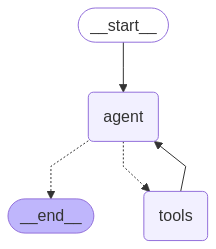

In [12]:
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [13]:
from langchain_core.messages import HumanMessage
question = HumanMessage(content='내가 10억짜리 집을 2채 가지고 있다면 세금을 얼마나 내나요?')
for chunk in graph.stream({'messages': [question]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()


================================ Human Message =================================

내가 10억짜리 집을 2채 가지고 있다면 세금을 얼마나 내나요?
================================== Ai Message ==================================
Tool Calls:
  get_tax_deductible (call_c0cSWpi7L0ZUzOF11CE9jcB6)
 Call ID: call_c0cSWpi7L0ZUzOF11CE9jcB6
  Args:
    question: 내가 10억짜리 집을 2채 가지고 있다면 공제액은 얼마인가요?
  get_market_value_rate (call_D50pgLov8t5a1oeEOS8YcDvv)
 Call ID: call_D50pgLov8t5a1oeEOS8YcDvv
  Args:
    question: 내가 10억짜리 집을 2채 가지고 있다면 공정시장가액비율은 어떻게 되나요?
  get_tax_base_equation (call_zO66gtppAYIYOrUtS7vXFgg4)
 Call ID: call_zO66gtppAYIYOrUtS7vXFgg4
  Args:
================================= Tool Message =================================
Name: get_tax_base_equation

주택에 대한 종합부동산세 과세표준은 다음과 같이 계산됩니다:  과세표준 = (주택의 공시가격 합산 - 공제금액) × 공정시장가액비율
================================== Ai Message ==================================
Tool Calls:
  get_house_tax (call_sKate7n28LbgvquuSAvNgXMx)
 Call ID: call_sKate7n28LbgvquuSAvNgXMx
  Args:
  